In [1]:
"""
通过对n日涨幅的加权，达到时序信息的效果。
非本质属性的特征无益，但不容易判断是否是非本质属性。高阶关联属性可能有用。
通过限制决策树的深度和列采样来减少过拟合。
时间较短只考虑的一只股票，没有考虑股票间的相关性。
"""
import warnings
warnings.simplefilter('ignore')
import gc
import re
import time
import os
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.metrics import accuracy_score,recall_score,f1_score
from scipy.stats import entropy, kurtosis
import xgboost as xgb
import seaborn as sns
from xgboost import plot_importance
import matplotlib.pyplot as plt
import pandas as pd
from math import *
from sklearn import datasets
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score
from sklearn.datasets.samples_generator import make_blobs
import numpy as np
import lightgbm as lgb
from IPython.display import display

pd.set_option('display.max_columns', None)
pd.set_option('max_columns', None)
pd.set_option('max_rows', None)
pd.set_option('float_format', lambda x: '%.6f' % x)

%matplotlib inline

d:\python36\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
d:\python36\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
pathf = os.path.join("..", "Question2", "Data")

trainpd = pd.read_csv(os.path.join(pathf, "Stock_1.csv"))
trainshape = trainpd.shape
targ = trainpd.columns[-1]
feature=trainpd.columns[1:-1]
periondlist=[1,3,5,10,20,60]
for i1 in feature:
    if i1.startswith("Price") or i1.startswith("Volume"):
        for per in periondlist:
            trainpd[i1+"_"+str(per)] =trainpd[i1] / (trainpd[i1].shift(per)+0.001)
feature=[item for item in trainpd.columns[1:] if item !=targ]
nolist=['VolumeFeature_7_3',
'VolumeFeature_3_1',
'VolumeFeature_7_10',
'VolumeFeature_8_20',
'PriceFeature_8',
'PriceFeature_8_60',
'VolumeFeature_2_1',
'VolumeFeature_2_20',
'VolumeFeature_7_1',
'VolumeFeature_8_3',
'PriceFeature_7',
'VolumeFeature_2',
'PriceFeature_7_1',
'PriceFeature_7_3',
'PriceFeature_7_5',
'PriceFeature_7_10',
'PriceFeature_7_20',
'PriceFeature_7_60',
'PriceFeature_8_1',
'PriceFeature_8_3',
'PriceFeature_8_5',
'PriceFeature_8_10',
'PriceFeature_8_20',
'VolumeFeature_2_3',
'VolumeFeature_2_5',
'VolumeFeature_2_10',
'VolumeFeature_2_60',
'VolumeFeature_8_1',
'VolumeFeature_8_5',
'VolumeFeature_8_10']
feature=[item for item in feature if item not in nolist]
# x = trainpd.iloc[:, 1:-1]
# y = trainpd.iloc[:,-1]
x = np.array(trainpd[feature])
y = np.array(trainpd[targ])

x_train, x_test, y_train,y_test = train_test_split(x, y, test_size=0.1, random_state=0)
p_num=sum(y_train)
n_num=y_train.shape[0]-p_num
w_pn = n_num/p_num
x_train, x_val, y_train,y_val = train_test_split(x_train,  y_train, test_size=0.2, random_state=0)

[03:14:35] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[0]	validation_0-auc:0.977024	validation_1-auc:0.96328
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.98663	validation_1-auc:0.963356
[2]	validation_0-auc:0.989406	validation_1-auc:0.971167
[3]	validation_0-auc:0.989776	validation_1-auc:0.966414
[4]	validation_0-auc:0.990302	validation_1-auc:0.967476
[5]	validation_0-auc:0.991168	validation_1-auc:0.972683
[6]	validation_0-auc:0.991815	validation_1-auc:0.976033
[7]	validation_0-auc:0.992773	validation_1-auc:0.977201
[8]	validation_0-auc:0.993978	validation_1-auc:0.977657
[9]	validation_0-auc:0.994318	validation_1-auc:0.983551
[10]	validation_0-auc:0.994768	validation_1-auc:0.984145
[11]	validation_0-auc:0.994844	validation_1-auc:0.984374
[12]	validation_0-auc:0.994885	validation_1-auc:0.984214
[13]	validation_

[151]	validation_0-auc:1	validation_1-auc:0.994128
[152]	validation_0-auc:1	validation_1-auc:0.994163
[153]	validation_0-auc:1	validation_1-auc:0.994169
[154]	validation_0-auc:1	validation_1-auc:0.994182
[155]	validation_0-auc:1	validation_1-auc:0.994211
[156]	validation_0-auc:1	validation_1-auc:0.994236
[157]	validation_0-auc:1	validation_1-auc:0.994215
[158]	validation_0-auc:1	validation_1-auc:0.994223
[159]	validation_0-auc:1	validation_1-auc:0.994211
[160]	validation_0-auc:1	validation_1-auc:0.994237
[161]	validation_0-auc:1	validation_1-auc:0.994259
[162]	validation_0-auc:1	validation_1-auc:0.994245
[163]	validation_0-auc:1	validation_1-auc:0.994225
[164]	validation_0-auc:1	validation_1-auc:0.994218
[165]	validation_0-auc:1	validation_1-auc:0.994198
[166]	validation_0-auc:1	validation_1-auc:0.994214
[167]	validation_0-auc:1	validation_1-auc:0.994243
[168]	validation_0-auc:1	validation_1-auc:0.994247
[169]	validation_0-auc:1	validation_1-auc:0.994244
[170]	validation_0-auc:1	valida

[312]	validation_0-auc:1	validation_1-auc:0.994578
[313]	validation_0-auc:1	validation_1-auc:0.994582
[314]	validation_0-auc:1	validation_1-auc:0.994577
[315]	validation_0-auc:1	validation_1-auc:0.994586
[316]	validation_0-auc:1	validation_1-auc:0.994586
[317]	validation_0-auc:1	validation_1-auc:0.994578
[318]	validation_0-auc:1	validation_1-auc:0.994573
[319]	validation_0-auc:1	validation_1-auc:0.994573
[320]	validation_0-auc:1	validation_1-auc:0.994564
[321]	validation_0-auc:1	validation_1-auc:0.994555
[322]	validation_0-auc:1	validation_1-auc:0.99457
[323]	validation_0-auc:1	validation_1-auc:0.99456
[324]	validation_0-auc:1	validation_1-auc:0.994572
[325]	validation_0-auc:1	validation_1-auc:0.994571
[326]	validation_0-auc:1	validation_1-auc:0.994585
[327]	validation_0-auc:1	validation_1-auc:0.99459
[328]	validation_0-auc:1	validation_1-auc:0.994592
[329]	validation_0-auc:1	validation_1-auc:0.9946
[330]	validation_0-auc:1	validation_1-auc:0.994602
[331]	validation_0-auc:1	validation_

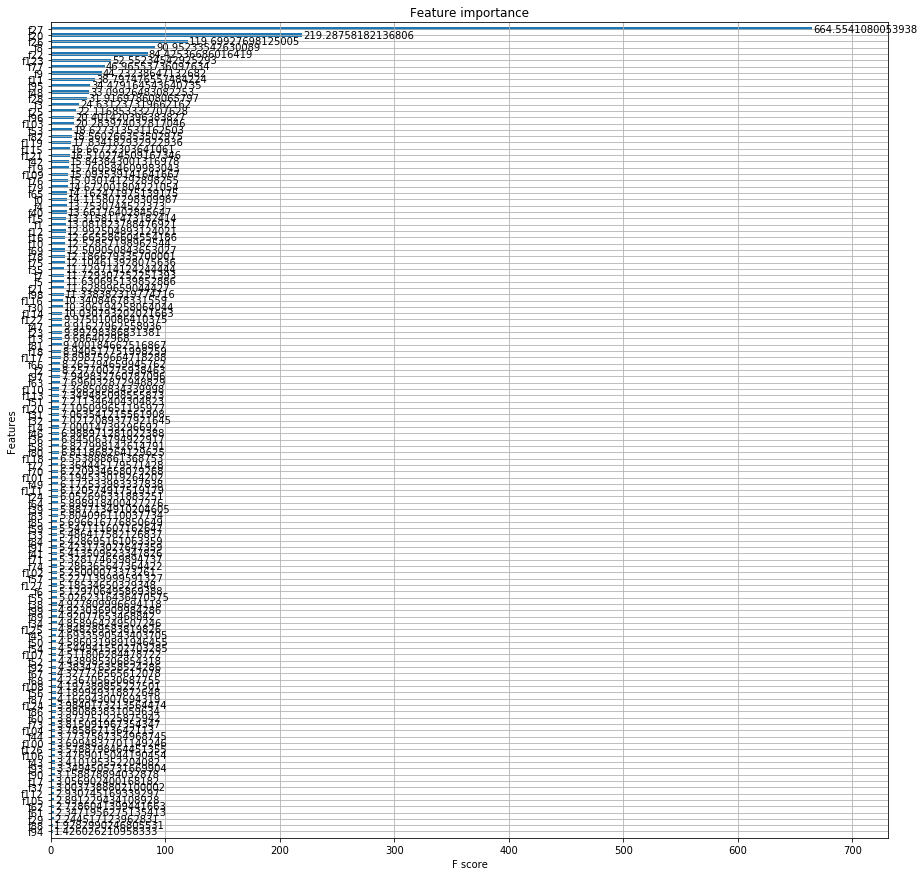

AUC Score: 0.992537
accuracy: 0.991665
recall: 0.802469
f1_score: 0.773810


In [3]:
clf = xgb.XGBClassifier(tree_method='hist', max_depth=8, learning_rate=0.1, verbosity=3,
                        scale_pos_weight=w_pn,eval_metric='auc', n_estimators=2000, colsample_bytree=0.9)
clf.fit(
    x_train, y_train,
    eval_set=[(x_train, y_train),
                (x_val, y_val)],
    early_stopping_rounds=50,
    verbose=True,
)
fig,ax = plt.subplots(figsize=(15,15))
for i1 in sorted({icon[0]:icon[1]for icon in zip(feature, clf.feature_importances_)}.items(), key=lambda x: -x[1]):
    print(i1)
xgb.plot_importance(clf, height=0.5,max_num_features=None,ax=ax,importance_type='gain')
plt.show()
y_predprob = clf.predict_proba(x_test)[:,1]
y_pred = np.where(y_predprob > 0.5, 1, 0)
auc = metrics.roc_auc_score(y_test, y_predprob)
print("AUC Score: %f" % auc)
accu = accuracy_score(y_test, y_pred)
print("accuracy: %f" % accu)        
recal = recall_score(y_test, y_pred)
print("recall: %f" % recal)        
f1 = f1_score(y_test, y_pred)
print("f1_score: %f" % f1)